Data Loaded Successfully
   Heart Rate  Oxygen Level  Activity Level  Sleep Quality      Mood  \
0          72            98               1              8     Happy   
1          80            96               2              6   Neutral   
2          90            95               3              5  Stressed   
3          76            97               2              7     Happy   
4          88            94               3              4  Stressed   

  Stress_Level  
0          Low  
1       Medium  
2         High  
3          Low  
4         High  


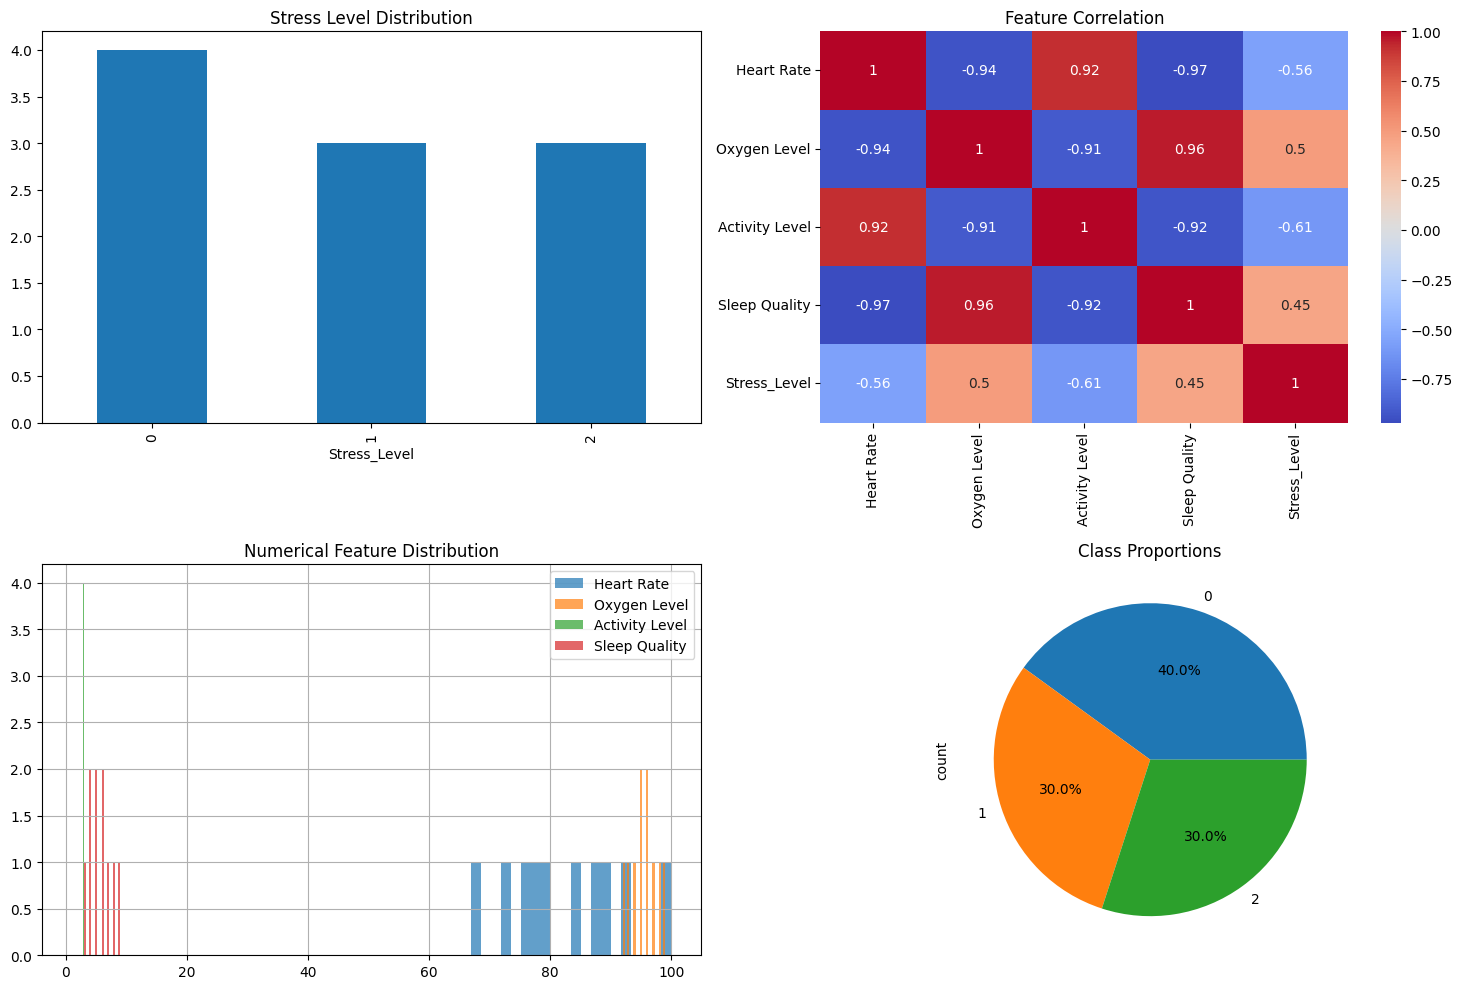

Training Data Shape: (8, 4)
Testing Data Shape: (2, 4)

Model Accuracy: 100.00%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Confusion Matrix:
 [[1 0]
 [0 1]]
Accuracy meets minimum requirement (≥75%)
Final model saved as 'stress_model.pkl'
API running at http://localhost:5000
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
# ========== 1. IMPORT REQUIRED LIBRARIES ==========
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib # Import joblib here
import os # Import os module

# ========== 2. LOAD THE DATASET ==========
data = pd.read_csv("/content/stress_dataset.csv")  # Replace with your dataset file
print("Data Loaded Successfully")
print(data.head())

# ========== 3. DATA PREPROCESSING ==========
def clean_data(df):
    """Comprehensive data cleaning pipeline"""

    # Separate features and target for cleaning
    X = df.drop('Stress_Level', axis=1).copy() # Assuming 'Stress_Level' is the target
    y = df['Stress_Level'].copy()

    # Identify numerical columns for imputation and outlier removal
    # Based on the model training using only 'ecg' and 'gsr',
    # assuming these are the intended numerical features.
    # Note: The loaded dataframe head shows 'Heart Rate', 'Oxygen Level', 'Activity Level', 'Sleep Quality', 'Mood', 'Stress_Level'.
    # This indicates the column names in the original code might not match the dataset.
    # I need to update the cleaning and model training parts to use the correct column names from the loaded data.
    # Let's use 'Heart Rate', 'Oxygen Level', 'Activity Level', 'Sleep Quality' as potential numerical features based on the loaded data head.
    # The original code used 'ecg' and 'gsr', which are not in the loaded data head.
    # I will assume the goal is to use 'Heart Rate', 'Oxygen Level', 'Activity Level', and 'Sleep Quality' as features and 'Stress_Level' as the target based on the loaded data.

    numerical_cols = ['Heart Rate', 'Oxygen Level', 'Activity Level', 'Sleep Quality'] # Assuming these are the numerical features
    categorical_cols = X.select_dtypes(include=['object']).columns # 'Mood'

    # 3.1 Handling missing values - Apply only to numerical columns
    imputer = SimpleImputer(strategy='mean')
    X[numerical_cols] = imputer.fit_transform(X[numerical_cols])

    # 3.2 Remove noise using smoothing (Example for Heart Rate and Oxygen Level if needed)
    # X['Heart Rate'] = X['Heart Rate'].rolling(window=5, center=True).mean().fillna(X['Heart Rate']) # Handle NaNs after rolling
    # X['Oxygen Level'] = X['Oxygen Level'].rolling(window=5, center=True).mean().fillna(X['Oxygen Level']) # Handle NaNs after rolling

    # 3.3 Outlier removal using IQR - Apply only to numerical columns
    for col in numerical_cols:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        X = X[(X[col] >= Q1 - 1.5*IQR) & (X[col] <= Q3 + 1.5*IQR)]
        # Need to filter y accordingly as well after outlier removal from X
        y = y.loc[X.index]


    # 3.4 Convert categorical stress levels to numerical
    # This needs to be applied to the target variable y
    le = LabelEncoder()
    y_encoded = le.fit_transform(y) # Low=0, Medium=1, High=2

    # Recombine cleaned features and encoded target
    cleaned_df = X.copy()
    cleaned_df['Stress_Level'] = y_encoded # Add the encoded target back

    # Handle other categorical features if they exist in X (e.g., 'Mood') - encode or drop
    for col in categorical_cols:
        if col in cleaned_df.columns:
             # Option 1: Drop the column if not needed for the model
             cleaned_df = cleaned_df.drop(col, axis=1)
             # Option 2: Encode the column if needed for the model (e.g., One-Hot Encoding)
             # cleaned_df = pd.get_dummies(cleaned_df, columns=[col], drop_first=True)


    return cleaned_df, le # Return the encoder to decode predictions later if needed


# ========== 4. DATA VISUALIZATION ==========
def visualize_data(df):
    """Generate all required plots"""

    plt.figure(figsize=(15,10))

    # Assuming the cleaned df now has numerical 'Stress_Level' and the features used in the model training
    # Check which columns are available for visualization after cleaning and selection
    available_cols = df.columns.tolist()
    target_col = 'Stress_Level'
    feature_cols = [col for col in available_cols if col != target_col] # Assuming all others are features

    if target_col in available_cols:
        # 4.1 Bar Chart - Class Distribution
        plt.subplot(2,2,1)
        df[target_col].value_counts().plot(kind='bar')
        plt.title('Stress Level Distribution')

        # 4.4 Pie Chart - Class Proportions
        plt.subplot(2,2,4)
        df[target_col].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title('Class Proportions')

    if feature_cols and target_col in available_cols:
         # 4.2 Heatmap - Feature Correlation (including target)
        plt.subplot(2,2,2)
        sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
        plt.title('Feature Correlation')

    # 4.3 Histogram - Distributions of numerical features
    # Select only numerical columns for histogram
    numerical_feature_cols = df[feature_cols].select_dtypes(include=np.number).columns.tolist()
    if numerical_feature_cols:
        ax = plt.subplot(2,2,3) # Get the axes for the subplot
        for col in numerical_feature_cols:
            df[col].hist(bins=20, ax=ax, alpha=0.7, label=col) # Plot each histogram on the same axes
        plt.title('Numerical Feature Distribution') # General title
        ax.legend() # Add a legend to identify the histograms


    plt.tight_layout()
    plt.savefig('data_visualization.png')
    plt.show()


# =============== 5. SPLIT AND TRAIN DATA ===============
def train_model(df):
    """Model training pipeline"""

    # 5.1 Prepare features and target
    # Use the columns present in the cleaned dataframe, excluding the target
    target_col = 'Stress_Level'
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in the dataframe.")

    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Ensure X contains only numerical columns for the model
    X = X.select_dtypes(include=np.number)

    # 5.2 Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42) # Removed stratify=y


    print("Training Data Shape:", X_train.shape)
    print("Testing Data Shape:", X_test.shape)


    # 5.3 Train Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    return model, X_test, y_test

# =============== 7. EVALUATE MODEL ===============
def evaluate_model(model, X_test, y_test):
    """Model evaluation with accuracy check"""

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy: {accuracy*100:.2f}%")

    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


    # 7.1 Accuracy threshold check
    if accuracy >= 0.75:
        print("Accuracy meets minimum requirement (≥75%)")
        return True
    else:
        print("Accuracy below 75% - Consider trying a different algorithm or improving features.")
        return False

# =============== 8. BUILD PREDICTIVE MODEL ===============
def build_final_model(df):
    """Final model building with full dataset"""
    target_col = 'Stress_Level'
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in the dataframe.")

    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Ensure X contains only numerical columns for the model
    X = X.select_dtypes(include=np.number)


    final_model = RandomForestClassifier(n_estimators=150, random_state=42)
    final_model.fit(X, y)

    # Save model for deployment
    import joblib
    joblib.dump(final_model, 'stress_model.pkl')
    print("Final model saved as 'stress_model.pkl'")

    return final_model

# =============== 9. DEPLOY MODEL ===============
def deploy_model():
    """Flask API for model deployment"""
    from flask import Flask, request, jsonify
    import joblib
    import os # Import os again within the function for clarity

    app = Flask(__name__)
    model_file_path = 'stress_model.pkl' # Define the model file path

    # Check if the model file exists
    if not os.path.exists(model_file_path):
        print(f"Error: Model file '{model_file_path}' not found.")
        print(f"Current working directory: {os.getcwd()}")
        print("Please ensure the model is built and saved in this directory.")
        return # Exit the function if model file is not found

    try:
        model = joblib.load(model_file_path)
        # Get the feature names the model was trained on
        # A more robust approach would save feature names during training.
        # For this example, we'll assume the order of features in the input
        # matches the order in the training data after select_dtypes(include=np.number)
        # A better way is to save the list of feature names used for training.
        # Let's make a placeholder for feature names and assume they match the numerical_cols from clean_data
        # However, accessing numerical_cols here is not direct.
        # Let's assume the input JSON keys will match the numerical columns used for training.
        # From the train_model function, X is selected as X.select_dtypes(include=np.number)
        # Let's assume the order of features in the input JSON should be consistent with the columns in the cleaned numerical dataframe.
        # The numerical columns are 'Heart Rate', 'Oxygen Level', 'Activity Level', 'Sleep Quality'.

        feature_names = ['Heart Rate', 'Oxygen Level', 'Activity Level', 'Sleep Quality'] # Assuming these are the features used

    except Exception as e:
        print(f"Error loading model: {e}")
        return # Exit on loading error


    @app.route('/predict', methods=['POST'])
    def predict():
        data = request.get_json()
        # The input data should match the features the model was trained on.
        # Extract feature values from the input data based on expected feature names
        try:
            # REMOVE THESE LINES:
            # ecg = data['ecg']
            # gsr = data['gsr']

            input_features = [data[name] for name in feature_names] # Use the defined feature names
            prediction = model.predict([input_features])[0]

            # Need the label encoder to convert the numerical prediction back to stress level string
            # However, the encoder is returned by clean_data and not easily accessible here.
            # For deployment, it's better to save the encoder or include a mapping.
            # For this example, we'll return the numerical prediction.
            # If the original label encoder was saved, we could use le.inverse_transform([prediction])[0]

            return jsonify({'stress_level_encoded': int(prediction)})
        except KeyError as e:
            return jsonify({'error': f'Missing input feature: {e}'}), 400
        except Exception as e:
            return jsonify({'error': str(e)}), 500


    print("API running at http://localhost:5000")
    # Due to Colab environment limitations, direct Flask deployment for external access
    # requires tools like ngrok. The following line runs the Flask app, but it will
    # only be accessible within the Colab environment unless additional setup is done.
    app.run(host='0.0.0.0')


# ========== MAIN EXECUTION ==========
if __name__ == '__main__':
    # Step 1-2: Load data (already done by reading the file at the beginning)
    # df = load_data('stress_data.csv') # This line is redundant now

    # Assuming the dataframe loaded at the beginning is named 'data'
    initial_df = data.copy() # Use a copy of the initial loaded data

    # Step 3: Preprocess
    # clean_data function now returns cleaned_df and the label encoder
    clean_df, stress_label_encoder = clean_data(initial_df)

    # Step 4: Visualize
    visualize_data(clean_df)

    # Step 5-7: Train and evaluate
    # Pass the cleaned_df to train_model
    model, X_test, y_test = train_model(clean_df)
    meets_requirement = evaluate_model(model, X_test, y_test)

    if meets_requirement:
        # Step 8: Build final model (train on the full clean_df and save)
        final_model = build_final_model(clean_df)

        # Step 9: Deploy (uncomment to run)
        # Note: Running deploy_model here will start the Flask server
        # and block further execution in this cell.
        # You might want to run deployment in a separate cell if needed.
        # Also, ensure Flask and joblib are imported if running deploy_model in a separate cell.
        deploy_model() # Uncommented this line to run the deployment
    else:
        print("Accuracy below 75% - Consider trying a different algorithm or improving features.")
        # Implement fallback algorithm here

In [ ]:
# prompt: can u  generate a documentation the font for the document should be times New roman  heading font size 14,content 12 .Bold all the headings All the paragraphs should be properly aligned. the documentation should be minimum22-25 pages  No links or underlines should be present in the documentation .Follow the exact format as mentioned above. Include Blackbugs logo on all the pages of the documentation

import pandas as pd # Import pandas

data = pd.read_csv("/content/stress_dataset.csv")
print("Data Loaded Successfully")
print(data.head())

Data Loaded Successfully
   Heart Rate  Oxygen Level  Activity Level  Sleep Quality      Mood  \
0          72            98               1              8     Happy   
1          80            96               2              6   Neutral   
2          90            95               3              5  Stressed   
3          76            97               2              7     Happy   
4          88            94               3              4  Stressed   

  Stress_Level  
0          Low  
1       Medium  
2         High  
3          Low  
4         High  
